<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_UPro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. На основе учебного ноутбука, проведите финальную подготовку данных. измените количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW 
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Реализуйте сегментацию базы Стройка на основе модели `PSPnet`. Статья для изучения [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

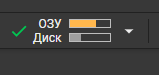


Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка


### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt 

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Импортируем библиотеку numpy
import numpy as np 

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами 
import os 

# Для генерации случайных чисел 
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image 

# очистка ОЗУ
import gc 

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака
#gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/construction_1024x768.zip', None, quiet=True)
#gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/construction_512x384.zip', None, quiet=True)
gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/construction_256x192.zip', None, quiet=True)

!unzip -q 'construction_256x192.zip' # распоковываем архив

## Решение

In [ ]:
# Глобальные параметры

# Ширина картинки
IMG_WIDTH = 192
# Высота картинки
IMG_HEIGHT = 256
# количество классов на изображении
NUM_CLASSES = 16
# Название папки с файлами обучающей выборки
TRAIN_DIRECTORY = 'train'
# Название папки с файлами проверочной выборки
VAL_DIRECTORY = 'val'

In [ ]:
# загрузим оригинальные изображения

# Создаем пустой список для хранений оригинальных изображений обучающей выборки
train_images = []
# Создаем пустой список для хранений оригинальных изображений проверочной выборки
val_images = []

# Проходим по всем файлам в каталоге по указанному пути  
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):   
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))               
    
print ('Обучающая выборка загружена') 
print ('Количество изображений: ', len(train_images)) 

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size   
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename), 
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))  

print ('Проверочная выборка загружена') 
print ('Количество изображений: ', len(val_images)) 

Обучающая выборка загружена
Количество изображений:  1900
Проверочная выборка загружена
Количество изображений:  100


In [ ]:
# загружаем сегментированные изображения

# Создаем пустой список для хранений оригинальных изображений обучающей выборки
train_segments = [] 
# Создаем пустой список для хранений оригинальных изображений проверочной выборки
val_segments = [] 

# Проходим по всем файлам в каталоге по указанному пути   
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')):   
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size  
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))                                                     
    
print ('Обучающая выборка загружена') 
print ('Количество изображений: ', len(train_segments)) 

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): 
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename), 
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))  

print ('Проверочная выборка загружена')
print ('Количество изображений: ', len(val_segments)) 

Обучающая выборка загружена
Количество изображений:  1900
Проверочная выборка загружена
Количество изображений:  100


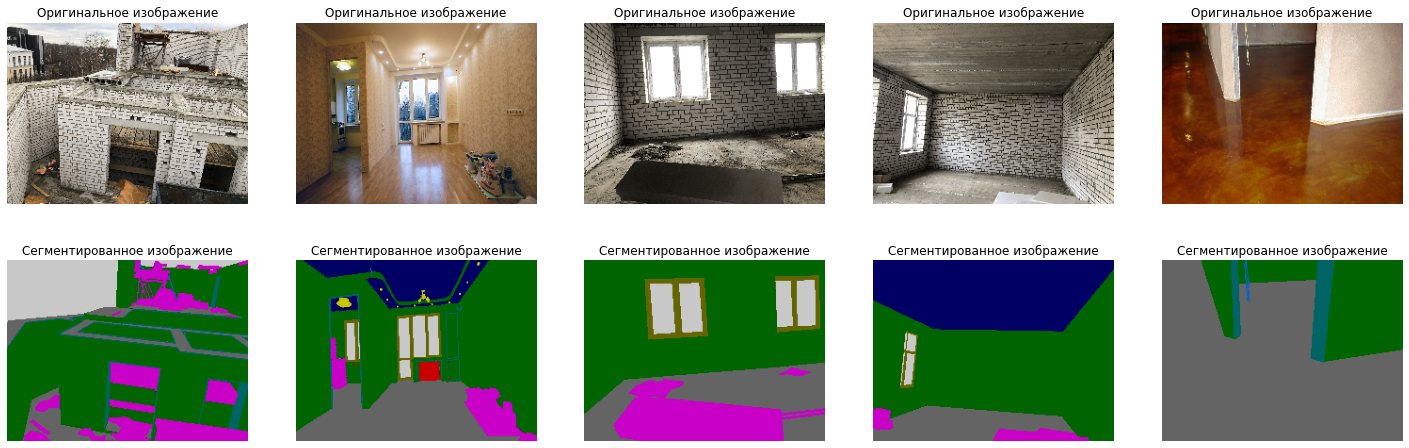

In [ ]:
# просмотр оригинальных изображений и соответствующих им сегментированных изображений

# создаем полотно
plt.figure(figsize=(25, 8))
for i in range(5):
    # выбираем рандомно номер изображения
    img = random.randint(0, len(train_images))

    plt.subplot(2, 5, i+1)
    plt.title('Оригинальное изображение')
    plt.imshow(train_images[img])
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.title('Сегментированное изображение')
    plt.imshow(train_segments[img])
    plt.axis('off')

plt.show()

In [ ]:
# зададим цвета пикселей каждого из 16 классов
FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
COLUMN = (100, 0, 0)            # Колонна (красный)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

# сохраним в множество
CLASS_LABELS = (FLOOR, CEILING, WALL, APERTURE, DOOR, WINDOW, COLUMN, RAILINGS, LADDER, INVENTORY, EXTERNAL, BATTERY, PEOPLE, LAMP, WIRE, BEAM)

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов
def rgb_to_labels(image_list):
    """
    Функция преобразует трехцветный канал изображения в метку класса
    На вход подается список изображений
    Возвращается список тензоров размера ширина на высота изображения
    """

    result = []
  
    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картинки
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS): 
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i
        result.append(y)
  
    return np.array(result)


# Функция преобразования тензора меток класса в цветное сегментированное изображение
def labels_to_rgb(image_list):
    """
    Функция преобразует метку класса в цветное сегментированное изображение
    На вход подается список тензоров с метками классов
    Возвращается цветное сегментированное изображение 
    """

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картинки
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселей класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)
  
    return np.array(result)

In [ ]:
# сформируем обучающую выборку

# создадим пустой список под выборку
x_train = []

# для всех изображений выборки
for img in train_images:
    # переводим в изображение в 3-хмерный массив 
    x = image.img_to_array(img)
    # Добавление элемента в выборку
    x_train.append(x)

# Перевод всей выборки в numpy
x_train = np.array(x_train)


# аналогично сформируем проверочную выборку
x_val = []
for img in val_images:
    x = image.img_to_array(img)
    x_val.append(x)

x_val = np.array(x_val)


# Преобразование сегментов в метки классов
y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

# посмотрим размерности
print(y_train.shape)
print(y_val.shape)
print(x_val.shape)
print(x_train.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)
(100, 192, 256, 3)
(1900, 192, 256, 3)


In [ ]:
# уменьшим количество сегментирующих классов до 7
y_train7 = y_train.copy()
y_train7[(y_train7 > 2) & (y_train7 < 6)] = 3
y_train7[(y_train7 > 5) & (y_train7 < 9)] = 4
y_train7[y_train7 == 9] = 5
y_train7[y_train7 > 9] = 6

y_val7 = y_val.copy()
y_val7[(y_val7 > 2) & (y_val7 < 6)] = 3
y_val7[(y_val7 > 5) & (y_val7 < 9)] = 4
y_val7[y_val7 == 9] = 5
y_val7[y_val7 > 9] = 6

In [ ]:
# Создаем модель
img_input = Input(shape=(192, 256, 3))

x = Conv2D(64, (3, 3), padding='same')(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

pool_2 = MaxPooling2D(2)(x)
pool_2 = Conv2D(128, (3, 3), padding='same')(pool_2)
pool_2 = BatchNormalization()(pool_2)
pool_2 = Activation('relu')(pool_2)
pool_2 = Conv2D(128, (3, 3), padding='same')(pool_2)
pool_2 = BatchNormalization()(pool_2)
pool_2 = Activation('relu')(pool_2)
pool_2 = Conv2D(128, (3, 3), padding='same')(pool_2)
pool_2 = BatchNormalization()(pool_2)
pool_2 = Activation('relu')(pool_2)

pool_4 = MaxPooling2D(4)(x)
pool_4 = Conv2D(256, (3, 3), padding='same')(pool_4)
pool_4 = BatchNormalization()(pool_4)
pool_4 = Activation('relu')(pool_4)
pool_4 = Conv2D(256, (3, 3), padding='same')(pool_4)
pool_4 = BatchNormalization()(pool_4)
pool_4 = Activation('relu')(pool_4)
pool_4 = Conv2D(256, (3, 3), padding='same')(pool_4)
pool_4 = BatchNormalization()(pool_4)
pool_4 = Activation('relu')(pool_4)

pool_8 = MaxPooling2D(8)(x)
pool_8 = Conv2D(512, (3, 3), padding='same')(pool_8)
pool_8 = BatchNormalization()(pool_8)
pool_8 = Activation('relu')(pool_8)
pool_8 = Conv2D(512, (3, 3), padding='same')(pool_8)
pool_8 = BatchNormalization()(pool_8)
pool_8 = Activation('relu')(pool_8)
pool_8 = Conv2D(512, (3, 3), padding='same')(pool_8)
pool_8 = BatchNormalization()(pool_8)
pool_8 = Activation('relu')(pool_8)

pool_16 = MaxPooling2D(16)(x)
pool_16 = Conv2D(1024, (3, 3), padding='same')(pool_16)
pool_16 = BatchNormalization()(pool_16)
pool_16 = Activation('relu')(pool_16)
pool_16 = Conv2D(1024, (3, 3), padding='same')(pool_16)
pool_16 = BatchNormalization()(pool_16)
pool_16 = Activation('relu')(pool_16)
pool_16 = Conv2D(1024, (3, 3), padding='same')(pool_16)
pool_16 = BatchNormalization()(pool_16)
pool_16 = Activation('relu')(pool_16)

up_2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(pool_2)
up_2 = BatchNormalization()(up_2)
up_2 = Activation('relu')(up_2)
up_2 = Conv2D(64, (3, 3), padding='same')(up_2)
up_2 = BatchNormalization()(up_2)
up_2 = Activation('relu')(up_2)
up_2 = Conv2D(64, (3, 3), padding='same')(up_2)
up_2 = BatchNormalization()(up_2)
up_2 = Activation('relu')(up_2)

up_4 = Conv2DTranspose(64, (3, 3), strides=(4, 4), padding='same')(pool_4)
up_4 = BatchNormalization()(up_4)
up_4 = Activation('relu')(up_4)
up_4 = Conv2D(64, (3, 3), padding='same')(up_4)
up_4 = BatchNormalization()(up_4)
up_4 = Activation('relu')(up_4)
up_4 = Conv2D(64, (3, 3), padding='same')(up_4)
up_4 = BatchNormalization()(up_4)
up_4 = Activation('relu')(up_4)

up_8 = Conv2DTranspose(64, (3, 3), strides=(8, 8), padding='same')(pool_8)
up_8 = BatchNormalization()(up_8)
up_8 = Activation('relu')(up_8)
up_8 = Conv2D(64, (3, 3), padding='same')(up_8)
up_8 = BatchNormalization()(up_8)
up_8 = Activation('relu')(up_8)
up_8 = Conv2D(64, (3, 3), padding='same')(up_8)
up_8 = BatchNormalization()(up_8)
up_8 = Activation('relu')(up_8)

up_16 = Conv2DTranspose(64, (3, 3), strides=(16, 16), padding='same')(pool_16)
up_16 = BatchNormalization()(up_16)
up_16 = Activation('relu')(up_16)
up_16 = Conv2D(64, (3, 3), padding='same')(up_16)
up_16 = BatchNormalization()(up_16)
up_16 = Activation('relu')(up_16)
up_16 = Conv2D(64, (3, 3), padding='same')(up_16)
up_16 = BatchNormalization()(up_16)
up_16 = Activation('relu')(up_16)

x = concatenate([img_input, x, up_2, up_4, up_8, up_16])
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(7, (1, 1), activation='softmax', padding='same')(x)

model = Model(img_input, x)

# Компилируем модель
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# обучаем модель
history = model.fit(x_train, y_train7, epochs=50, batch_size=16,
                    validation_data=(x_val, y_val7))

Epoch 1/50
119/119 [==============================] - 87s 608ms/step - loss: 1.1548 - sparse_categorical_accuracy: 0.6110 - val_loss: 2.8128 - val_sparse_categorical_accuracy: 0.3094
Epoch 2/50
119/119 [==============================] - 69s 581ms/step - loss: 0.9022 - sparse_categorical_accuracy: 0.6971 - val_loss: 2.9089 - val_sparse_categorical_accuracy: 0.2667
Epoch 3/50
119/119 [==============================] - 69s 581ms/step - loss: 0.8050 - sparse_categorical_accuracy: 0.7292 - val_loss: 1.5578 - val_sparse_categorical_accuracy: 0.4687
Epoch 4/50
119/119 [==============================] - 69s 581ms/step - loss: 0.7703 - sparse_categorical_accuracy: 0.7416 - val_loss: 1.2497 - val_sparse_categorical_accuracy: 0.5721
Epoch 5/50
119/119 [==============================] - 69s 582ms/step - loss: 0.7232 - sparse_categorical_accuracy: 0.7573 - val_loss: 1.0963 - val_sparse_categorical_accuracy: 0.6387
Epoch 6/50
119/119 [==============================] - 69s 581ms/step - loss: 0.6992 -

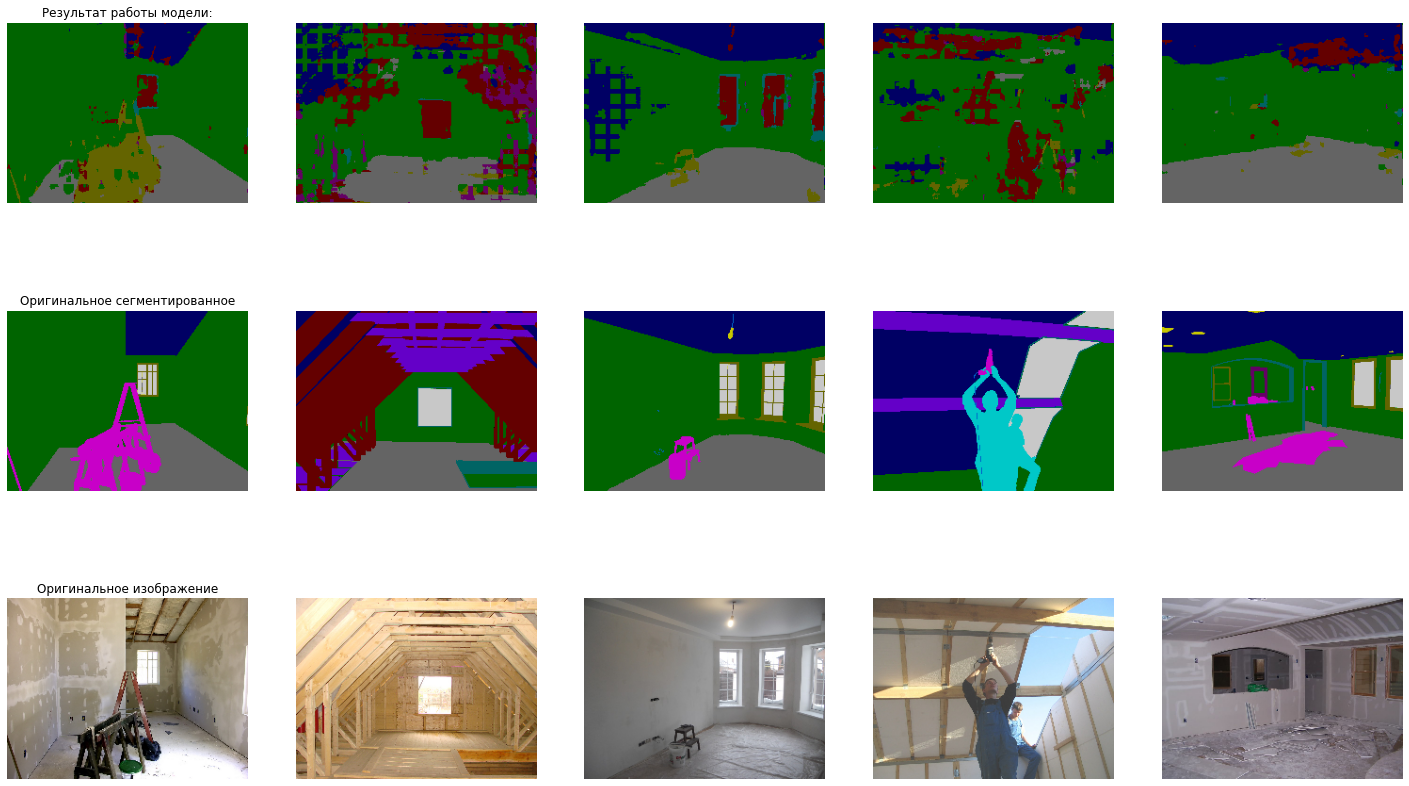

In [ ]:
# Генерация случайного списка индексов в количестве count между (0, len(x_val)
indexes = np.random.randint(0, len(x_val), 5)
    
# Вычисление предсказания сети для картинок с отобранными индексами
predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

# Подготовка цветов классов для отрисовки предсказания
orig = labels_to_rgb(predict[..., None])
fig, axs = plt.subplots(3, 5, figsize=(25, 15)) 
    
# Отрисовка результата работы модели
for i in range(5):
    # Отображение на графике в первой линии предсказания модели
    axs[0, 0].set_title('Результат работы модели:')
    axs[0, i].imshow(orig[i])
    axs[0, i].axis('off')

    # Отображение на графике во второй линии сегментированного изображения из y_val
    axs[1, 0].set_title('Оригинальное сегментированное')
    axs[1, i].imshow(val_segments[indexes[i]])
    axs[1 ,i].axis('off')

    # Отображение на графике в третьей линии оригинального изображения
    axs[2, 0].set_title('Оригинальное изображение')
    axs[2, i].imshow(val_images[indexes[i]])
    axs[2 ,i].axis('off')

plt.show()